# 1d polynya growth model

https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/JC092iC07p07049

In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units

In [2]:
# Save to file
df = pd.read_csv('./data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

In [3]:

time_range = slice(datetime(2024,1,2), datetime(2024,1,17))

# time_range = slice(datetime(2019,1,13), datetime(2019,1,20))

DS = xr.open_dataset(f'./data/polynya_size/daily_polynya_{time_range.stop.year}_sic15_v3.nc')
DS = DS.sel(time = time_range)

DS['length'] = DS['l_max'] - DS['l_min']

DS['t'] = ((DS.time.values - DS.time.values[0]) / np.timedelta64(1, 's')) * units('s').to('hour')

In [ ]:
# polynya length

Xp = 0 * units('km')


Va = 20 * units('m/s')

# Vi = 30 * units('cm/s') # rate of pack ice advection from shore
Vi = 0.03 * Va

Fi = 1 * units('cm/hour') # ice produciton rate

Hi = 1 * units('m') # frazil ice collection depth

t = np.arange(0, 360) * units('hour')



def xp_over_time(Vi, t, Fi, Hi = 1 * units('m')):
    
    # Hi : frazil ice collection depth
    
    C = - Vi * Hi / Fi
    Xp = - C * (1 - np.exp(-t * Fi / Hi))
    Xp = Xp.to('km')
    Xip = (Vi*t).to('km')


    return Xp, Xip 




def convert_to_k(T):
    
    if T.units == 'degree_Celsius':
        T = T.to('degree_Kelvin')
    elif T.units == 'delta_degree_Celsius':
        print('T!! should not be delta deg C')
    return T
        
def find_Qlu(Tw, sigma, eo):
    
    Tw = convert_to_k(Tw)
    qlu = sigma * eo * Tw**4
    return qlu.to('W/m2')


def find_Qld(Ta, sigma, ea):
    Ta = convert_to_k(Ta)
    qld = sigma * ea * Ta**4
    return qld.to('W/m2')


def find_Qs(Ta, Tw, rho_a, Cpa, Va):
    
    Ta = Ta.magnitude * units('delta_degree_Celsius')
    Tw = Tw.magnitude * units('delta_degree_Celsius')
    
    Ch = 2e-3 # sensible heat coefficient

    qs = rho_a * Ch * Cpa * Va * (Ta-Tw)
    
    return qs.to('W/m2')


In [444]:

# for now, ignore evaporative latent heat flux, and shortwave radiation for winter

Ta = -20 * units('degC')
rho_a = cst['rho_a']
Va = 20 * units('m/s')

Tf = -1.8 *units('delta_degC')
Tw = -1.8 * units('degC')

# define positive upward
Qlu = find_Qlu(Tw, cst['sigma_sb'], 0.98)
Qld = -find_Qld(Ta, cst['sigma_sb'], 0.95)
Qs = -find_Qs(Ta, Tw, rho_a, cst['Cp_a'], Va)
print(Qs)

Qnet = Qlu + Qld + Qs

dHdt = (Qnet / (cst['L_i'] * cst['rho_i'])).to('cm/hour')

dHdt

649.3872000000001 watt / meter ** 2


<Quantity(0.836209064, 'centimeter / hour')>

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
plt.bar(0, Qlu)
plt.bar(1, Qld)
plt.bar(2, Qs)
plt.bar(3, Qnet)

In [446]:
# Q = m * C * dT


# dt = 12 *  units('hour')
# rho_o = cst['rho_o']
# H = 16 * units('m')
# dT = (Qnet * dt / (rho_o * H * cst['Cp_o'])).to_base_units()

rho_o = cst['rho_o']
H = 16 * units('m')
dT = (Tw.magnitude * units('delta_degC') - Tf)

(dT * rho_o * H * cst['Cp_o'] / Qnet).to('hour')

# change 

<Quantity(0.0, 'hour')>

<BarContainer object of 16 artists>

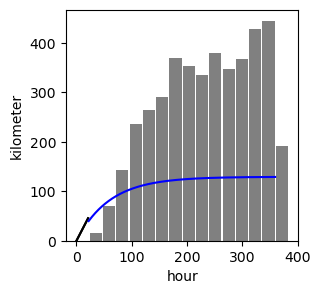

In [447]:
fig, ax= plt.subplots(figsize=(3,3))

Fi = 0.0001 * units('cm/hour') # ice produciton rate
Xp, Xip  = xp_over_time(Vi, t[:22], Fi, Hi = 0.5 * units('m'))
plt.plot(t[:22], Xip, c='k')
plt.plot(t[:22], Xp, c='k')

Fi = dHdt #5 * units('cm/hour') # ice produciton rate
Xp, Xip  = xp_over_time(Vi, t[22:], Fi, Hi = 0.5 * units('m'))
plt.plot(t[22:], Xp, c='b')

plt.bar(DS.t.values, DS.length.values, width=22, align='edge', color='gray')

In [108]:
DS.t.values

array([  0.,  24.,  48.,  72.,  96., 120., 144., 168.])